In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

import types

In [2]:
STORAGE_PATH = "../../persisted_data/feather/{}.feather"

def load_data_set(name):
    data = pd.read_feather(STORAGE_PATH.format(name))
    return data

In [3]:
# get some data sets
ibm = load_data_set("IBM_normalized")
jnj = load_data_set("JNJ_normalized")
nasdaq = load_data_set("nasdaq10spy_30shift_normalized")
all_stocks_sets = {
    # future interval: data set
    10: load_data_set("all_stocks20spy_10shift_normalized"),
    20: load_data_set("all_stocks20spy_20shift_normalized"),
    50: load_data_set("all_stocks20spy_50shift_normalized"),
    100: load_data_set("all_stocks20spy_100shift_normalized")
}


In [4]:
# simple function used to plot a distribution of values using a histogram
def plot_distribution(y_values, xlabel="future price in relation to current price", ylabel="number of occurrences",
                      range=[-3,3]):
    size = len(y_values)
    n_bins = min(int(size / 10), 100)
    plt.hist(y_values, bins=n_bins, range=range)
    plt.axvline(y_values.mean(), color="red", linestyle="dashed")
    plt.tight_layout()
    plt.title("Distribution plot with sample size {}".format(size))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [5]:
def future_price_log(samples):
    plot_distribution(samples["future_price"], range=[0, 5])
    plot_distribution(np.log((samples["future_price"])))

# show difference in the distribution of future prices with and without taking the log
future_price_log(nasdaq_samples)

NameError: name 'nasdaq_samples' is not defined

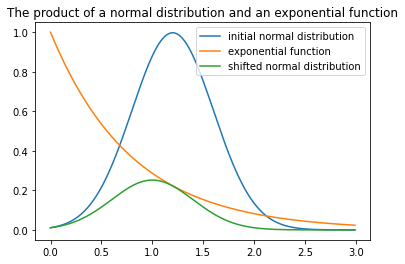

In [33]:
# this function demonstrates the functionality used in data_set_modifier to change the mean of a normal distribution
# a log normal distribution can be shifted the same way, the log has to be taken before this process
def shift_normal(mean=1.1, new_mean=1, std=0.4):
    x = np.arange(0, 3, .01)
    factor = np.exp(-(np.power(mean, 2) - np.power(new_mean, 2)) / (2 * np.power(std, 2)))
    f = factor * np.exp((np.power(x - mean, 2) - np.power(x - new_mean, 2)) / (2 * np.power(std, 2)))
    norm = stats.norm.pdf(x, mean, std)
    plt.title("The product of a normal distribution and an exponential function")
    plt.plot(x, norm)
    plt.plot(x, f)
    plt.plot(x, f * norm)
    plt.legend(["initial normal distribution", "exponential function", "shifted normal distribution"])
    plt.show()
    
# show example functions used in the operation
shift_normal(1.2, 1)

In [34]:
# the mean of a feature is usually not 1
# with this function the distribution of a value in a set of samples can be shifted, by removing some samples
def move_dataset_to_mean(samples, desired_mean=1, feature="future_price", transform=lambda x: x, start_of_deletions=lambda x: 0):
    # we want to shift a log normal distribution
    # to simplify this process we take the logarithm and treat the distribution as a normal distribution from now on
    y = transform(samples[feature])

    # calculate the characteristic values of the normal distribution
    mean = np.mean(y)
    std = np.std(y)

    # define a "start" of the exponential function by setting the point where the keep probability should be = 1
    start = start_of_deletions(y) if isinstance(start_of_deletions, types.LambdaType) else start_of_deletions

    # define the probability distribution which is used to shift the sample distribution
    keep_probability = lambda x: np.exp(
        (np.power(x + start - mean, 2) - np.power(x + start - transform(desired_mean), 2)) / (2 * np.power(std, 2)))

    # create a set of random numbers between 0 and 1
    random_sample = np.random.random_sample(len(samples))
    # define which samples will be kept
    keep = random_sample < keep_probability(y)

    return samples[keep]

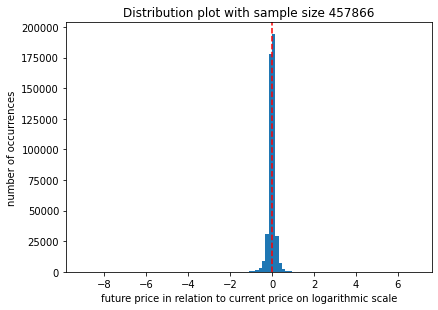

original number of samples: 457866, average: 1.022158953013935, std: 1.8371327451111432


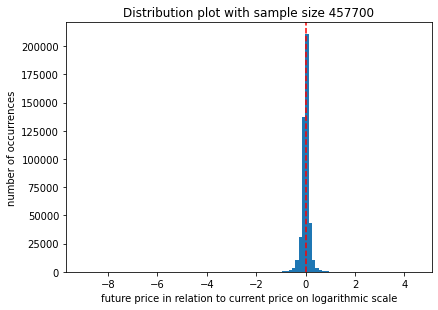

modified number of samples: 457700, average: 1.0160358737585036, std: 0.2584333980644368


In [20]:
samples = nasdaq_samples
# plot the distribution before and after shifting it
samples_mean = np.mean(samples["future_price"])
samples_std = np.std(samples["future_price"])
plot_distribution(np.log(samples["future_price"]), "future price in relation to current price on logarithmic scale")
print("original number of samples: {}, average: {}, std: {}".format(len(samples), samples_mean, samples_std))
modified = move_dataset_to_mean(samples)
modified_mean = np.mean(modified["future_price"])
modified_std = np.std(modified["future_price"])
plot_distribution(np.log(modified["future_price"]), "future price in relation to current price on logarithmic scale")
print("modified number of samples: {}, average: {}, std: {}".format(len(modified), modified_mean, modified_std))



In [39]:
def correlation_with_future(samples):
    correlations = pd.DataFrame()
    for indicator in samples:
        corr = samples[indicator].corr(np.log(samples['future_price']))

        new_row = pd.DataFrame({"indicator": [indicator], "correlation": [corr]})
        correlations = pd.concat([correlations, new_row])
    return correlations
                                       
# show the correlation test
correlation_with_future(nasdaq_samples)

,indicator,correlation
0,index,0.000732
0,volatility10,0.028046
0,volatility20,0.041646
0,volatility50,0.044028
0,volatility100,0.014252
0,volatility200,0.010661
0,sma10,0.022984
0,sma20,0.025981
0,sma50,0.034243
0,sma100,0.031709


In [50]:
def plot_correlations(interval, correlations, plot_columns=2):
    number_of_indicators = len(correlations)
    fig, axs = plt.subplots(number_of_indicators // plot_columns + number_of_indicators % plot_columns, plot_columns, figsize=(30,60))
    fig.text(0.5, 0.04, "prediction interval", ha="center")
    fig.text(0.04, 0.5, "correlation", va="center", rotation="vertical")
    for index, indicator in enumerate(correlations):
        axs[index // plot_columns][index % plot_columns].title.set_text(indicator)
        axs[index // plot_columns][index % plot_columns].plot(intervals, correlations[indicator])
    
    plt.subplots_adjust(top=5)
    plt.show()

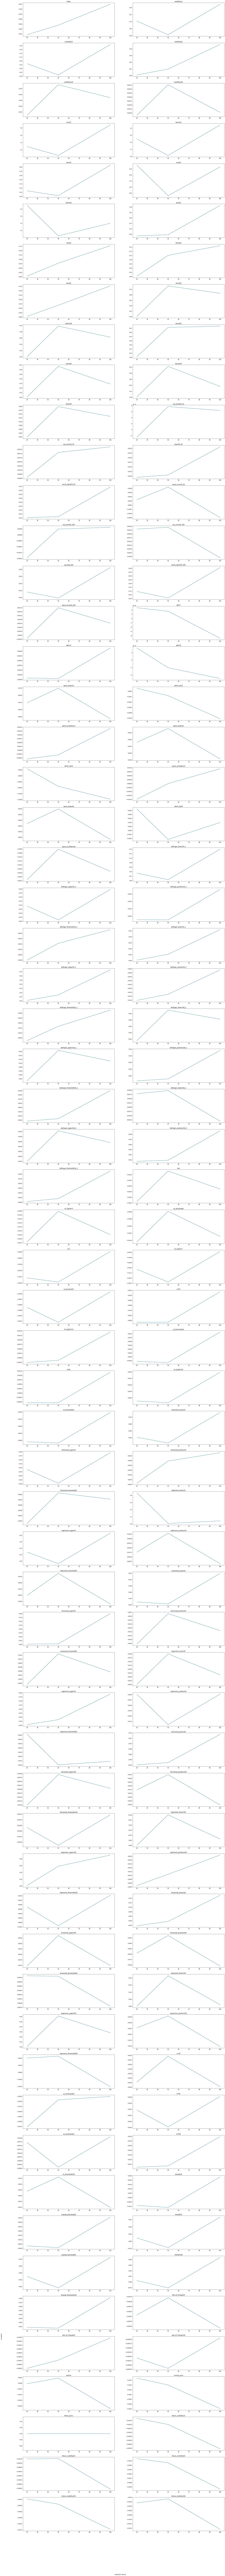

In [51]:

def analyze_indicator_correlation(sample_sets, future_indicator):
    correlations = dict.fromkeys(list(sample_sets.values())[0], np.array([]))
    for interval in sample_sets:
        future = np.abs(sample_sets[interval][future_indicator])
        for feature_name, feature_values in sample_sets[interval].iteritems():
            corr = np.abs(feature_values).corr(future)
            correlations[feature_name] = np.append(correlations[feature_name], corr)
    
    return correlations

intervals = list(all_stocks_sets.keys())[1:]
correlations = analyze_indicator_correlation(all_stocks_sets, "future_price")
correlations.update((feature, corr[1:]) for feature, corr in correlations.items())
plot_correlations(intervals, correlations)
